In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class FNN(object):
    """Build a general FeedForward neural network
    Parameters
    ----------
    learning_rate : float
    drop_out : float
    Layers : list
        The number of layers
    N_hidden : list
        The numbers of nodes in layers
    D_input : int
        Input dimension
    D_label : int
        Label dimension
    Task_type : string
        'regression' or 'classification'
    L2_lambda : float
        
    Returns
    -------

    """
    def __init__(self, learning_rate, drop_keep, Layers, N_hidden, D_input, D_label, Task_type='regression', L2_lambda=0.0):
        
        #var
        self.learning_rate = learning_rate
        self.drop_keep = np.array(drop_keep).astype(np.float32)
        self.Layers = Layers
        self.N_hidden = N_hidden
        self.D_input = D_input
        self.D_label = D_label
        self.Task_type = Task_type
        self.L2_lambda = L2_lambda
        
        # Placeholders
        self.inputs = tf.placeholder(tf.float32, [None, D_input], name="inputs")
        self.labels = tf.placeholder(tf.float32, [None, D_label], name="labels")
        self.drop_keep_rate = tf.placeholder(tf.float32, name="dropout_keep")
        
        # accumulate l2 regularization
        self.l2_penalty = tf.constant(0.0)
        
        self.build('FNN')
        
    def weight_init(self,shape):
        # shape : list [in_dim, out_dim]
        # can change initialization here
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)

    def bias_init(self,shape):
        # can change initialization here
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)
    
    def variable_summaries(self, var, name):
        with tf.name_scope(name+'summaries'):
            mean = tf.reduce_mean(var)
            tf.scalar_summary('mean/' + name, mean)
        with tf.name_scope(name+'stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.scalar_summary('stddev/' + name, stddev)
        tf.scalar_summary('max/' + name, tf.reduce_max(var))
        tf.scalar_summary('min/' + name, tf.reduce_min(var))
        tf.histogram_summary(name, var)

    def layer(self,in_tensor, in_dim, out_dim, layer_name, act=tf.nn.relu):
        with tf.name_scope(layer_name):
            with tf.name_scope(layer_name+'weights'):
                weights = self.weight_init([in_dim, out_dim])
                self.variable_summaries(weights, layer_name + '/weights')
            with tf.name_scope(layer_name+'biases'):
                biases = self.bias_init([out_dim])
                self.variable_summaries(biases, layer_name + '/biases')
            with tf.name_scope(layer_name+'Wx_plus_b'):
                pre_activate = tf.matmul(in_tensor, weights) + biases
                tf.histogram_summary(layer_name + '/pre_activations', pre_activate)
            activations = act(pre_activate, name='activation')
            tf.histogram_summary(layer_name + '/activations', activations)
        return activations, tf.nn.l2_loss(weights)

    def drop_layer(self,in_tensor):
            #tf.scalar_summary('dropout_keep', self.drop_keep_rate)
        dropped = tf.nn.dropout(in_tensor, self.drop_keep_rate)
        return dropped

    def build(self, prefix):
        # build networks

        incoming = self.inputs
        layer_nodes = [self.D_input] + self.N_hidden
        
        #hidden layers
        self.hid_layers=[]
        
        for l in range(self.Layers):
            incoming,l2_loss= self.layer(incoming,layer_nodes[l],layer_nodes[l+1],prefix+str(l),act=tf.nn.relu)
            self.l2_penalty+=l2_loss
            print('Add dense layer: relu with drop_keep:%s' %self.drop_keep)
            print('    %sD --> %sD' %(layer_nodes[l],layer_nodes[l+1]))
            self.hid_layers.append(incoming)
            #drop out layer
            incoming = self.drop_layer(incoming)
            
        #output layer
        self.output,l2_loss= self.layer(incoming,layer_nodes[-1],self.D_label, layer_name='output',act=tf.identity)
        self.l2_penalty+=l2_loss
        print('Add output layer: linear')
        print('    %sD --> %sD' %(layer_nodes[-1],self.D_label))
        
        #loss
        if self.Task_type=='regression':
            with tf.name_scope('SSE'):
                self.loss=tf.reduce_mean(tf.nn.l2_loss((self.output - self.labels)))
                tf.scalar_summary('loss', self.loss)
        else:
            entropy = tf.nn.softmax_cross_entropy_with_logits(self.output, self.labels)
            with tf.name_scope('cross entropy'):
                self.loss = tf.reduce_mean(entropy)
                tf.scalar_summary('loss', self.loss)
            with tf.name_scope('accuracy'):
                correct_prediction = tf.equal(tf.argmax(self.output, 1), tf.argmax(self.labels, 1))
                self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                tf.scalar_summary('accuracy', self.accuracy)
        #train
        with tf.name_scope('train'):
            self.train_step = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss + self.l2_penalty*self.L2_lambda)


    def shufflelists(self,lists):
        ri=np.random.permutation(len(lists[1]))
        out=[]
        for l in lists:
            out.append(l[ri])
        return out
    
    

In [3]:
inputs=[[0,0],[0,1],[1,0],[1,1]]
outputs=[0,1,1,0]
X=np.array(inputs).reshape((4,1,2)).astype('int16')
Y=np.array(outputs).reshape((4,1,1)).astype('int16')

In [4]:
a=FNN(1e-5, 1.0, 1, [8], 2, 1)

Add dense layer: relu with drop_keep:1.0
    2D --> 8D
Add output layer: linear
    8D --> 1D


In [5]:
#sess.close()
sess = tf.InteractiveSession()
tf.initialize_all_variables().run()
merged = tf.merge_all_summaries()
train_writer = tf.train.SummaryWriter('log' + '/train',sess.graph)

In [11]:
k=0.0
for i in range(100000):
    k+=1
    summary, _ = sess.run([merged,a.train_step],feed_dict={a.inputs:X.reshape((4,2)),a.labels:Y.reshape((4,1)),a.drop_keep_rate:1.0})
    train_writer.add_summary(summary, k)

[[  6.66400979e-09]
 [  1.00000000e+00]
 [  1.00000000e+00]
 [ -6.66403821e-09]]


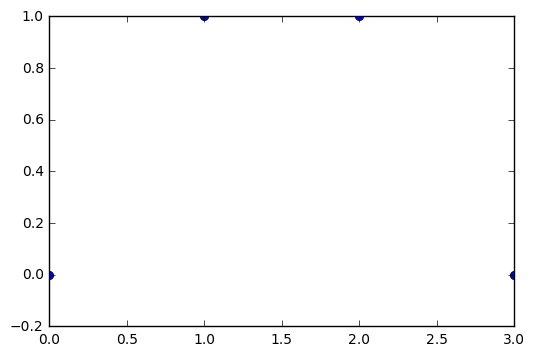

In [12]:
pY=sess.run(a.output,feed_dict={a.inputs:X.reshape((4,2)),a.drop_keep_rate:1.0})
print(pY)
plt.plot(pY,'o')